In [1]:
import numpy as np
import scipy
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, MDS
from sklearn.covariance import shrunk_covariance
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import mpl

import dill
import os

import torch
from utils.generate_and_plot_signals import generate_signals, plot_signals, plot_source_signals
from utils import UDEC_Network_Gen_Data, draw_states, ttest_for_clusters
from utils.calc_fun import calc_diff

os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
plt.rcParams['font.family']=['Arial', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

font = {'family':['Arial', 'Times New Roman'], 'color':'k', 'weight':'normal', 'size':10 }
colors = sns.color_palette('tab10')

# Generate or load data

In [3]:
# generate 50 random trials

n_trials = 50
n_ch = 6
n_times = 1001

raw_data = np.empty((n_trials, n_ch, n_times))
Atrue = np.random.random([n_ch, n_ch])

for t in range(n_trials):
    Strue = generate_signals(stationary=False)
    raw_data[t] = Atrue.dot(Strue)

X = raw_data[0]

# with open('./saves/generate_data.pkl', 'wb') as f:
#     dill.dump([Strue, Atrue, raw_data], f)

In [4]:
with open('./saves/generate_data.pkl', 'rb') as f:
    [Strue, Atrue, raw_data] = dill.load(f)

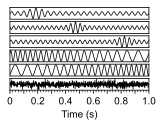

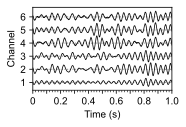

In [5]:
plot_signals(Strue, figsize=(2.5, 1.5));
plot_source_signals(raw_data[0], figsize=(2.5, 1.5), color='k');

# Calculate spatial covariance matrix

In [6]:
times = raw_data.shape[2]
chs = raw_data.shape[1]
lag_num = 200
half_lag = int(lag_num*0.5)
len_t = times-lag_num

avg_data = np.mean(raw_data, axis=0)
crop_eeg = np.zeros((chs, len_t))

Cov_mat = np.empty((len_t, chs, chs))
Cov_uptri = np.empty(( len_t, int(chs*((chs+1)/2)) ))
Cov_diag = np.empty((len_t, chs))

index = 0
for t in range(half_lag, len_t+half_lag):
    crop_eeg[:, index] = avg_data[:, t]

    # calculate covariance
    cov = np.cov(avg_data[:, t-half_lag:t+half_lag]) 
    # cov = shrunk_covariance(cov, shrinkage=0.01)
    Cov_mat[index] = cov
    Cov_uptri[index] = cov[np.triu_indices(cov.shape[0], k=0)]
    Cov_diag[index] = np.diagonal(cov)
    index += 1

Cov_uptri.shape

(801, 21)

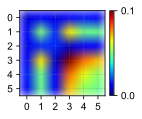

In [7]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(Cov_mat[50], interpolation='none', vmin=0.0, vmax=0.1, cmap='jet') 
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 0.1])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,6,1), np.arange(0,6,1), fontdict=font);
ax.set_yticks(np.arange(0,6,1), np.arange(0,6,1), fontdict=font);
plt.show();

# Calculate spatial pattern distance

## distance in observation space

In [8]:
tp = Cov_mat.shape[0]

cov_dist_o = np.full((tp, tp), np.nan)

for i in range(tp):
    for j in range(i+1, tp):        
        cov1 = Cov_mat[i]
        cov2 = Cov_mat[j]

        evals,_ = scipy.linalg.eigh(cov1,cov2)
        dist = np.log(evals[-1])

        cov_dist_o[i,j] = dist

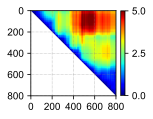

In [9]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(cov_dist_o, interpolation='none', vmin=0, vmax=5, cmap='jet',);
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 2.5, 5])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,801,200), np.arange(0,801,200), fontdict=font);
ax.set_yticks(np.arange(0,801,200), np.arange(0,801,200), fontdict=font);
plt.show();

## distance in source space

In [10]:
tp = Cov_mat.shape[0]

cov_dist_s = np.full((tp, tp), np.nan)

for i in range(tp):
    for j in range(i+1, tp):        
        cov1 = Cov_mat[i]
        cov2 = Cov_mat[j]

        d2 = (np.log(scipy.linalg.eigvalsh(cov1,cov2))**2).sum(axis=-1)
        riemann_dist = np.sqrt(d2)

        cov_dist_s[i,j] = riemann_dist

In [1]:
# Alternatively, calculations can be performed using the geomstats package.

# import geomstats.geometry.spd_matrices as spd
# from geomstats.geometry.spd_matrices import SPDAffineMetric

# dim = 6
# manifold = spd.SPDMatrices(dim)
# manifold.equip_with_metric(SPDAffineMetric)

# tp = Cov_mat.shape[0]
# cov_dist_s = np.full((tp, tp), np.nan)
# for i in range(tp):
#     for j in range(i+1, tp):        
#         cov1 = Cov_mat[i]
#         cov2 = Cov_mat[j]

#         riemann_dist = manifold.metric.dist(cov1, cov2)

#         cov_dist_s[i,j] = riemann_dist


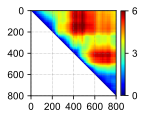

In [11]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(cov_dist_s, interpolation='none', vmin=0, vmax=6, cmap='jet',);
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 3, 6])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,801,200), np.arange(0,801,200), fontdict=font);
ax.set_yticks(np.arange(0,801,200), np.arange(0,801,200), fontdict=font);
plt.show();

# Multi-dimensional Scaling

In [12]:
mds = MDS(n_components=6, dissimilarity='precomputed', metric=True, 
          n_jobs=32, random_state=3, normalized_stress='auto')


In [13]:
cov_dist_o /= (np.nanmax(cov_dist_o))

dist_o_symm = np.ones_like(cov_dist_o)
for i in range(dist_o_symm.shape[0]):
    for j in range(i+1, dist_o_symm.shape[0]):
        dist_o_symm[i,j] = cov_dist_o[i,j]
        dist_o_symm[j,i] = cov_dist_o[i,j]

features_dist_o = mds.fit_transform(dist_o_symm)

In [14]:
cov_dist_s /= (np.nanmax(cov_dist_s))

dist_s_symm = np.ones_like(cov_dist_s)
for i in range(dist_s_symm.shape[0]):
    for j in range(i+1, dist_s_symm.shape[0]):
        dist_s_symm[i,j] = cov_dist_s[i,j]
        dist_s_symm[j,i] = cov_dist_s[i,j]

features_dist_s = mds.fit_transform(dist_s_symm)

# Data normlization

In [16]:
norm_cov_diag = np.log(50*Cov_diag)

norm_dist_o = 10*features_dist_o

norm_dist_s = 10*features_dist_s

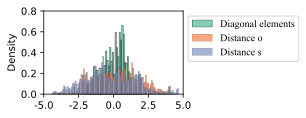

In [17]:
import warnings
warnings.filterwarnings('ignore')

font = {'family':['Times New Roman', 'Arial', ], 'weight':'normal', 'size':10 }
colors = sns.color_palette('Set2')

plt.figure(figsize=(2.5, 1.5))

sns.histplot(norm_cov_diag.flatten(), bins=40, stat='density', legend=False, color=colors[0], alpha=0.8, )
sns.histplot(norm_dist_o.flatten()+0.2, bins=100, stat='density', legend=False, color=colors[1], alpha=0.8, )
sns.histplot(norm_dist_s.flatten()-0.2, bins=100, stat='density', legend=False, color=colors[2], alpha=0.8, )

plt.xlim([-5, 5])
plt.ylim([0, 0.8])

plt.legend(labels=['Diagonal elements', 'Distance o', 'Distance s'], prop=font, bbox_to_anchor=(1.0, 1.0));

In [18]:
input_data_raw = np.hstack((norm_cov_diag, norm_dist_o, norm_dist_s))
print(input_data_raw.shape)

#[samples, features]
input_data = torch.from_numpy(input_data_raw).type(torch.FloatTensor) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

(801, 18)
cuda:0


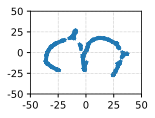

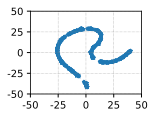

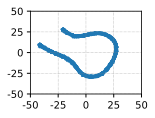

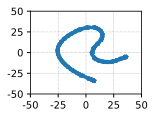

In [39]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

for data in [norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw]:
    tsne_2d = tsne.fit_transform(data)    

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
                marker='*', s=10, color=sns.color_palette('Paired')[1],
                )

    ax = plt.gca()
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')

    plt.yticks([-50,-25,0,25,50],[-50,-25,0,25,50])
    plt.xticks([-50,-25,0,25,50],[-50,-25,0,25,50])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

# Train AutoEncoder Network

In [40]:
EPOCHS_PRE = 1001
LR_PRE = 1e-3 # dynamic adjust learning rate
BATCH_SIZE = 32

autoencoder = UDEC_Network_Gen_Data.AutoEncoder().to(device)
checkpoint = { "epoch": 0, "best": float("inf") }
file_path_prefix = './gen_data_udec_saves/'
ae_save_path = file_path_prefix + 'autoencoder.pth'

UDEC_Network_Gen_Data.pretrain(train_data=input_data, model=autoencoder, savepath=ae_save_path, checkpoint=checkpoint, 
                               num_epochs=EPOCHS_PRE, file_path_prefix=file_path_prefix, batch_size=BATCH_SIZE, lr=LR_PRE)

epoch [1/1001], MSE_loss:2.07149
epoch [2/1001], MSE_loss:1.29551
epoch [3/1001], MSE_loss:0.36171
epoch [4/1001], MSE_loss:0.93282
epoch [5/1001], MSE_loss:0.34433
epoch [6/1001], MSE_loss:0.73890
epoch [7/1001], MSE_loss:0.23465
epoch [8/1001], MSE_loss:0.54542
epoch [9/1001], MSE_loss:0.35992
epoch [10/1001], MSE_loss:0.14802
epoch [11/1001], MSE_loss:0.37006
epoch [12/1001], MSE_loss:0.36744
epoch [13/1001], MSE_loss:0.12970
epoch [14/1001], MSE_loss:0.39291
epoch [15/1001], MSE_loss:0.34873
epoch [16/1001], MSE_loss:0.08875
epoch [17/1001], MSE_loss:0.35156
epoch [18/1001], MSE_loss:0.08241
epoch [19/1001], MSE_loss:0.28655
epoch [20/1001], MSE_loss:0.35909
epoch [21/1001], MSE_loss:0.26421
epoch [22/1001], MSE_loss:0.38888
epoch [23/1001], MSE_loss:0.17103
epoch [24/1001], MSE_loss:0.30168
epoch [25/1001], MSE_loss:0.09326
epoch [26/1001], MSE_loss:0.52139
epoch [27/1001], MSE_loss:0.36412
epoch [28/1001], MSE_loss:0.12125
epoch [29/1001], MSE_loss:0.05783
epoch [30/1001], MSE_lo

## latent features visualization

In [41]:
input_data_device = input_data.to(device)

latent_features = autoencoder.encode(input_data_device).detach().cpu().numpy()

print(latent_features.shape)

(801, 3)


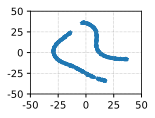

In [42]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

tsne_2d = tsne.fit_transform(latent_features)

fig, axi1=plt.subplots(1, figsize=(2, 1.5))
axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
            marker='*', s=10, color=sns.color_palette('Paired')[1],
            )

ax = plt.gca()
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.grid(True, linewidth=0.5, color='gray', linestyle=':')

plt.yticks([-50,-25,0,25,50],[-50,-25,0,25,50])
plt.xticks([-50,-25,0,25,50],[-50,-25,0,25,50])

ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
            labelbottom=True, labelleft=True, direction='out',width=1)
plt.show()

# Train clustering network

In [43]:
tmp = input_data_raw.copy()

np.random.shuffle(tmp)
np.random.shuffle(tmp)

data_shuffle = torch.from_numpy(tmp).type(torch.FloatTensor) 

In [44]:
num_clusters = [3, 5, 7]

EPOCHS = 10001
BATCH_SIZE = 1024
lr = 0.3
file_path_prefix = './gen_data_udec_saves/'

for n_c in num_clusters:

    autoencoder = UDEC_Network_Gen_Data.AutoEncoder().to(device)
    ae_save_path = file_path_prefix + 'autoencoder.pth'
    checkpoint = torch.load(ae_save_path)
    autoencoder.load_state_dict(checkpoint['state_dict'])

    dec = UDEC_Network_Gen_Data.DEC(n_clusters=n_c, autoencoder=autoencoder, hidden=3, cluster_centers=None, alpha=2.0).to(device)

    dec_save_path = file_path_prefix + 'dec-' + str(n_c) + '-clusters' + '.pth'
    checkpoint = { "epoch": 0, "best": float("inf") }
    UDEC_Network_Gen_Data.train(data=data_shuffle, model=dec, num_epochs=EPOCHS, 
                                n_cluster=n_c, draw_pic=True, lr=lr, file_path_prefix=file_path_prefix,
                                savepath=dec_save_path, checkpoint=checkpoint, batch_size=BATCH_SIZE)

Training
plotting
Epochs: [0/10001] Loss:0.11073914170265198
Epochs: [1000/10001] Loss:0.00167814118321985
Epochs: [2000/10001] Loss:0.001181481871753931
Epochs: [3000/10001] Loss:0.0009485266637057066
Epochs: [4000/10001] Loss:0.0008080087136477232
plotting
Epochs: [5000/10001] Loss:0.0007120841182768345
Epochs: [6000/10001] Loss:0.0006414756644517183
Epochs: [7000/10001] Loss:0.0005869956221431494
Epochs: [8000/10001] Loss:0.000543285917956382
Epochs: [9000/10001] Loss:0.000507283431943506
plotting
Epochs: [10000/10001] Loss:0.0004770095692947507
Training
plotting
Epochs: [0/10001] Loss:0.16422392427921295
Epochs: [1000/10001] Loss:0.003993510268628597
Epochs: [2000/10001] Loss:0.002707979641854763
Epochs: [3000/10001] Loss:0.00213730544783175
Epochs: [4000/10001] Loss:0.0018013797234743834
plotting
Epochs: [5000/10001] Loss:0.0015756426146253943
Epochs: [6000/10001] Loss:0.0014116070233285427
Epochs: [7000/10001] Loss:0.0012859589187428355
Epochs: [8000/10001] Loss:0.001185938483104

# K-Means clustering of latent features 

In [20]:
data = torch.from_numpy(input_data_raw).type(torch.FloatTensor)
num_clusters = [3, 5, 7]

latent_vec = np.empty( (len(num_clusters), data.size()[0], 3) )  # [n_c, frames, n_hidden]
pred_labels = np.empty( (len(num_clusters), data.size()[0]) )
pred_center = []

file_path_prefix = './gen_data_udec_saves/'
for ind, n_c in enumerate(num_clusters): 

    # load model
    autoencoder = UDEC_Network_Gen_Data.AutoEncoder()

    dec = UDEC_Network_Gen_Data.DEC(n_clusters=n_c, autoencoder=autoencoder, hidden=3, cluster_centers=None, alpha=2.0)
    dec_save_path = file_path_prefix + 'dec-' + str(n_c) + '-clusters' + '.pth'
    checkpoint = torch.load(dec_save_path)
    dec.load_state_dict(checkpoint['state_dict']);

    # calculate latent vectors
    latent_vec[ind] = autoencoder.encode(input_data).detach().cpu().numpy()

    # get cluster centers
    cluster = KMeans(n_clusters=n_c, random_state=0, n_init=50*n_c).fit(latent_vec[ind])

    # get cluster labels
    centroid = cluster.cluster_centers_
    pred_center.append(centroid)
    pred_labels[ind] = cluster.labels_ 

pred_labels += 1

In [21]:
# with open('./gen_data_udec_saves/gen_data_udec_clustering_results.pkl', 'wb') as f:
#     dill.dump([pred_center, pred_labels, centroid, input_data_raw, latent_vec], f)

In [11]:
with open('./gen_data_udec_saves/gen_data_udec_clustering_results.pkl', 'rb') as f:
    [pred_center, pred_labels, centroid, input_data_raw, latent_vec] = dill.load(f)

# T-SNE visualization

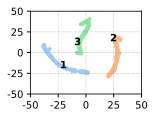

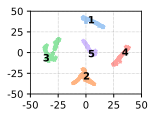

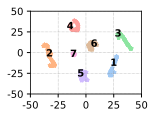

In [22]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

colors = sns.color_palette('pastel')

for ind, n_c in enumerate(num_clusters): 

    lf_with_center = np.vstack((latent_vec[ind], pred_center[ind]))

    kmeans_2d_with_center = tsne.fit_transform(lf_with_center)    
    kmeans_2d = kmeans_2d_with_center[:-n_c, :]
    kmeans_2d_center = kmeans_2d_with_center[-n_c:, :]

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    for i in range(n_c):
        axi1.scatter(kmeans_2d[pred_labels[ind] == i+1, 0], 
                      kmeans_2d[pred_labels[ind] == i+1, 1],
                      marker='*',
                      s=10,
                      color=colors[i],
                    )
        axi1.text(kmeans_2d_center[i,0], kmeans_2d_center[i,1], 
                  i+1, fontsize=10, fontweight='semibold', 
                  verticalalignment='center', horizontalalignment='center', 
                  color='black', 
                )

    ax = plt.gca()
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')

    plt.yticks([-50,-25,0,25,50],[-50,-25,0,25,50])
    plt.xticks([-50,-25,0,25,50],[-50,-25,0,25,50])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

# Find the index of cluster centers

In [42]:
euc_center_index = []
rie_center_index = []

riemann_dist_symmetry = np.zeros_like(cov_dist_s)
for i in range(cov_dist_s.shape[0]):
    for j in range(i+1, cov_dist_s.shape[0]):
        riemann_dist_symmetry[i,j] = cov_dist_s[i,j]
        riemann_dist_symmetry[j,i] = cov_dist_s[i,j]

# Euclidean distance of lantent vectors
for i, n_c in enumerate(num_clusters):
    tmp_c = []
    for n in range(n_c):
        distance = np.sum(np.square(latent_vec[i][pred_labels[i]==(n+1)] - pred_center[i][n]), axis=1)
        index = distance.argmin()
        tmp_c.append( np.argwhere(pred_labels[i]==(n+1))[index][0] )
    euc_center_index.append(tmp_c)

# Riemann distance
for i, n_c in enumerate(num_clusters):
    tmp_c = []
    for n in range(n_c):

        tmp = riemann_dist_symmetry[pred_labels[i]==(n+1), :]
        tmp2 = tmp[:, pred_labels[i]==(n+1)]
        distance = np.sum(tmp2, axis=0)

        index = distance.argmin()
        tmp_c.append( np.argwhere(pred_labels[i]==(n+1))[index][0] )
    rie_center_index.append(tmp_c)

In [43]:
euc_center_index

[[322, 547, 249],
 [389, 692, 205, 612, 223],
 [466, 765, 258, 108, 524, 208, 224]]

In [44]:
rie_center_index

[[359, 615, 118],
 [419, 699, 113, 541, 289],
 [454, 701, 321, 67, 581, 159, 237]]

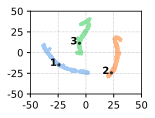

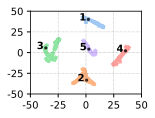

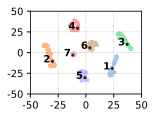

In [100]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

colors = sns.color_palette('pastel')

for ind, n_c in enumerate(num_clusters): 

    lf_with_center = np.vstack((latent_vec[ind], pred_center[ind]))

    kmeans_2d_with_center = tsne.fit_transform(lf_with_center)    
    kmeans_2d = kmeans_2d_with_center[:-n_c, :]
    kmeans_2d_center = kmeans_2d_with_center[-n_c:, :]

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    for i in range(n_c):
        axi1.scatter(kmeans_2d[pred_labels[ind] == i+1, 0], 
                      kmeans_2d[pred_labels[ind] == i+1, 1],
                      marker='*',
                      s=10,
                      color=colors[i],
                    )
        axi1.scatter( kmeans_2d[rie_center_index[ind][i], 0],
                      kmeans_2d[rie_center_index[ind][i], 1],
                      marker='.',
                      s=20,
                      color='black', alpha=0.7
                    )
        axi1.text(kmeans_2d[rie_center_index[ind][i], 0]-5, 
                  kmeans_2d[rie_center_index[ind][i], 1]+2, 
                  i+1, fontsize=10, fontweight='semibold', 
                  verticalalignment='center', horizontalalignment='center', 
                  color='black', 
                )

    ax = plt.gca()
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')

    plt.yticks([-50,-25,0,25,50],[-50,-25,0,25,50])
    plt.xticks([-50,-25,0,25,50],[-50,-25,0,25,50])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

# Plot microstate series

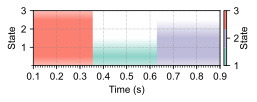

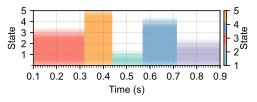

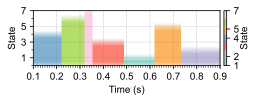

In [90]:
for n_c in range(len(num_clusters)):
    draw_states.draw_state_blocks_for_generated_data(pred_labels[n_c], figsize=(3.5, 1.0), 
                                                     n_clusters=int(np.max(pred_labels[n_c])),
                                                     colorbar_fraction=0.015, tmin=0.1, tmax=0.9, 
                                                     colorbar_ticks=[], euc_centers=[], rie_centers=[]);

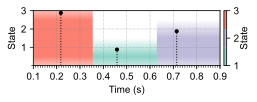

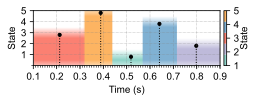

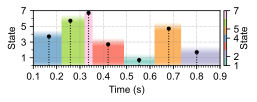

In [89]:
for n_c in range(len(num_clusters)):
    draw_states.draw_state_blocks_for_generated_data(pred_labels[n_c], figsize=(3.5, 1.0), 
                                                     n_clusters=int(np.max(pred_labels[n_c])),
                                                     colorbar_fraction=0.015, tmin=0.1, tmax=0.9, 
                                                     colorbar_ticks=[], euc_centers=[], rie_centers=rie_center_index[n_c]);

# t-test of clustering results

[]


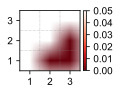

[]


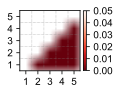

[]


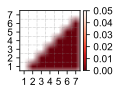

In [42]:
for n_c in range(len(num_clusters)):
    p_res = ttest_for_clusters.distance_ttest(pred_labels[n_c], cov_dist_s, samp_num=1000)
    ttest_for_clusters.draw_test_mat(p_res, corr_p=True)

In [12]:
import importlib
importlib.reload(ttest_for_clusters)

p_res, distance_dist = ttest_for_clusters.distance_ttest(pred_labels[1], cov_dist_s, samp_num=1000, get_distribution=True)

print(distance_dist.keys())

dict_keys(['12null', '12samp', '13null', '13samp', '14null', '14samp', '15null', '15samp', '23null', '23samp', '24null', '24samp', '25null', '25samp', '34null', '34samp', '35null', '35samp', '45null', '45samp'])


In [20]:
print(np.mean(distance_dist['12null']))
print(np.mean(distance_dist['12samp']))

print(np.std(distance_dist['12null']))
print(np.std(distance_dist['12samp']))

1.1627950855664393
5.0956495815192175
0.6242810132336359
0.47352144130175483


In [18]:
pres = scipy.stats.ttest_ind(distance_dist['12samp'], distance_dist['12null'], alternative='greater')

pres

TtestResult(statistic=175.501675767744, pvalue=0.0, df=2998.0)

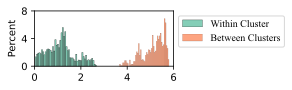

In [59]:
import warnings
warnings.filterwarnings('ignore')

font = {'family':['Times New Roman', 'Arial', ], 'weight':'normal', 'size':10 }
colors = sns.color_palette('Set2')

plt.figure(figsize=(2.5, 1.0))

sns.histplot(distance_dist['12null'], bins=50, stat='percent', legend=False, color=colors[0], alpha=0.8)
sns.histplot(distance_dist['12samp'], bins=50, stat='percent', legend=False, color=colors[1], alpha=0.8)
# sns.histplot(norm_dist_s.flatten()-0.2, bins=100, stat='density', legend=False, color=colors[2], alpha=0.8, )

plt.xlim([0, 6])
plt.ylim([0, 8])
plt.yticks([0,4,8], [0,4,8])

plt.legend(labels=['Within Cluster', 'Between Clusters'], prop=font, bbox_to_anchor=(1.0, 1.0));

# Calculate errors

In [8]:
for i in range(3):
    # SSE, Distance, CH_Score, SI_Score, DB_Score
    values = calc_diff(crop_eeg.T, pred_labels[i])
    print(values)

(139.14622626208737, 11.79602586730325, 0.24025478573185807, -0.0331568875939483, 49.51361831657223)
(139.02326819193416, 11.790812872399178, 0.2959363347430919, -0.13715026176821027, 50.286351931332426)
(137.70059109646957, 11.734589515465359, 1.4698076239867888, -0.17660296018620866, 27.908638095709556)
